# Cluster Analysis - Soft Clustering

In this section we do cluster analysis on taxi data from 2013, provided from Chicago (website: https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew).
We try to find pattern in the data, identify them and in addition to that we are interested in labeling these cluster patterns.

We are going to do different cluster analysis:

- customer types based on different features
- location based clustering

In general we do a hard and soft clustering, but in this part we perform the soft clustering. The soft clustering we use is the Gaussian Mixture Model.

Our procedure in this part is structured in the following way. For every different cluster analysis we do the following:

- small preprocessing
- deciding for the number of clusters
- process cluster analysis
- analyze und label the clusters

<hr style="border: 1px solid #8888;">

In [1]:
# import all necessary packages
import pandas as pd
import numpy as np
import warnings
from pandas.core.common import SettingWithCopyWarning
#warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [2]:
# import datasets
df_chicago = pd.read_csv("data/datasets/df_chicago.csv.zip")

## Functions defined for cluster analysis

### 1) Score functions

When researching for the best score to use when deciding which number of cluster to choose for the Gaussian Mixture Model (soft-clustering), we found the Silhouette score and the Bayesian information criterion (BIC).

Functions for those methods:

#### Silhouette score

In [3]:
def silhoutte(input_data, num_clus):

    #input data: part of df to cluster

    clusters = []
    scores = []

    for k in range(num_clus):
        
        model_clus = GaussianMixture(n_components = k+2, n_init = 15) #defaults: init_params='kmeans'
        labels = model_clus.fit_predict(input_data)
        
        clusters.append(k+1)
        scores.append(silhouette_score(input_data, labels = labels, sample_size=1000,random_state=42))
        #defaults: metric=euclidian
        
    return clusters, scores

#### Bayesian information criterion (BIC)

In [4]:
def bic(input_data, num_clus):

    #input data: part of df to cluster

    clusters = []
    scores = []

    for k in range(num_clus):
        
        model_clus = GaussianMixture(n_components = k+2, n_init = 15) #defaults: init_params='kmeans'
        model_clus.fit(input_data)
        
        clusters.append(k+1)
        scores.append(model_clus.bic(input_data))

        #defaults: metric=euclidian
        
    return clusters, scores

### 2) Scaling function

Data scaling function:

In [5]:
# method for scaling the data 
def scaling_data(df1):
    
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df1)
    df_scaled = pd.DataFrame(df_scaled, columns=df1.columns, 
                                            index=df1.index)
    
    return df_scaled

### 3) Plotting functions:

#### Plot cluster information:

In [6]:
def plot_information_about_clusters(df, feature_list, cluster_column):
    
    fig = plt.figure(figsize=(14, 18))
    
    for i in range(1, len(feature_list)+1):
        plt.subplot(np.floor(len(feature_list)/2).astype(int)+1, 2, i)
        sns.boxplot(y=df[feature_list[i-1]], 
                    x = df[cluster_column], 
                    palette="bright",
                    showmeans=True,
                    meanprops={"marker": "+",
                       "markeredgecolor": "black",
                       "markersize": "10"}).set_title("Cluster - " + feature_list[i-1]).set_fontsize('18')
        plt.tight_layout()
    
    plt.subplot(np.floor(len(feature_list)/2).astype(int)+1, 2, len(feature_list)+1)
    ax = sns.countplot(x=cluster_column, data=df, palette="bright")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Amount")
    ax.set_title('Cluster - Amount',fontsize=18)
    fig.tight_layout()

    for container in ax.containers:
        ax.bar_label(container)

#### Plot clusters (scatterplot):

In [56]:
def plot_cluster_scatter(x_column, y_column, df, x_label, y_label):

    colors = {
        2: '#16C835', #green
        1: '#FF7C00',#orange
        4: '#8B2BE2',#violet
        5: '#843C0C',#brown
        0: '#023EFF',#blue
        6: '#FF1493',#rosa
        3:'#FF0000',#red
        7:'#808080'#grey
        # Add more colors for other clusters if needed
    }

    # Create the scatter plot
    plt.figure(figsize=(8, 8))  # Adjust the figure size as needed

    # Use hue parameter to color the data points based on the 'cluster' column
    sns.scatterplot(x=x_column, y=y_column,data=df,hue='cluster', palette=colors)

    # Add labels and legend
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    legend = plt.legend(title='Clusters', loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)  # Adjust the bbox_to_anchor as needed

    # Move the legend outside and above the plot
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the top margin (0.95) as needed
    # Show the plot
    plt.show()

In [58]:
# Custom colors for clusters (sorted)
cluster_colors = ['#1f77b4',  # Blue
                  '#ff7f0e',  # Orange
                  '#2ca02c',  # Green
                  '#d62728',  # Red
                  '#9467bd',  # Purple
                  '#8c564b',  # Brown
                  '#e377c2',  # Pink
                  '#7f7f7f',  # Gray
                  '#bcbd22',  # Yellow
                  '#17becf']  # Cyan

# Function to create convex hull polygons for each cluster
def create_convex_hulls(df, x_col, y_col, cluster_col):
    convex_hulls = {}
    for cluster_id, cluster_data in df.groupby(cluster_col):
        points = cluster_data[[x_col, y_col]].values
        hull = ConvexHull(points)
        hull_points = points[hull.vertices]
        convex_hulls[cluster_id] = hull_points
    return convex_hulls

# Function to plot the scatter plot with convex hull boundaries and markers
def plot_scatter_with_hulls(df, x_col, y_col, cluster_col, label_col, size_tuple, dp_size, x_label, y_label, plot_title, leg_loc, anchor):
    # Create convex hulls
    convex_hulls = create_convex_hulls(df, x_col, y_col, cluster_col)
    
    # Plot the scatter plot with convex hull boundaries and markers
    plt.figure(figsize=size_tuple)
    for idx, (cluster_id, cluster_data) in enumerate(df.groupby(cluster_col)):
        color = cluster_colors[idx % len(cluster_colors)]  # Use custom colors cyclically
        hull_points = convex_hulls[cluster_id]
        hull_polygon = plt.Polygon(hull_points, alpha=0.2, facecolor=color, edgecolor=color, linewidth=2)
        plt.gca().add_patch(hull_polygon)
        
        inner_points = cluster_data.drop_duplicates([x_col, y_col]).loc[:, [x_col, y_col]]
        plt.scatter(inner_points[x_col], inner_points[y_col], label=cluster_data[label_col].iloc[0], s=dp_size, c=color)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(plot_title)
    plt.legend(loc=leg_loc, bbox_to_anchor=anchor) 
    plt.grid(True)
    plt.show()

<hr style="border: 1px solid #8888;">

## Preprocessing

### Preprocessing for clustering: `start_time_hourly`, `Trip_Miles` and `Trip_Minutes`

To better interpret and analzye the clusters after processing, we convert the `Trip_Seconds`to `Trip_Minutes`. On the one hand we do this simply because minutes are easier to evaluate and on the other hand because the `Trip_Seconds` are always in 60 second-steps anyway.

In [7]:
df_chicago_cluster = df_chicago[['start_time_hourly','Trip_Seconds',"Trip_Miles"]]
df_chicago_cluster

,start_time_hourly,Trip_Seconds,Trip_Miles
0,0,900.0,2.7
1,0,240.0,0.4
2,0,1920.0,0.6
3,0,180.0,1.0
4,0,240.0,0.3
...,...,...,...
8974515,23,540.0,1.4
8974516,23,1860.0,5.9
8974517,23,720.0,2.0
8974518,23,660.0,3.5


In [8]:
df_chicago_cluster['Trip_Minutes'] = df_chicago_cluster['Trip_Seconds']/60
df_chicago_cluster.drop(['Trip_Seconds'], axis = 1,inplace =True)

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_12727/2135727942.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chicago_cluster['Trip_Minutes'] = df_chicago_cluster['Trip_Seconds']/60
/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_12727/2135727942.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chicago_cluster.drop(['Trip_Seconds'], axis = 1,inplace =True)


In [9]:
df_chicago_cluster = df_chicago_cluster[(df_chicago_cluster['Trip_Miles'] < df_chicago_cluster['Trip_Miles'].quantile(0.95))]
df_chicago_cluster = df_chicago_cluster[(df_chicago_cluster['Trip_Minutes'] < df_chicago_cluster['Trip_Minutes'].quantile(0.95))]

In [10]:
# Drop unrealistic fast trips
df_chicago_cluster["velocity"] = (df_chicago_cluster["Trip_Miles"]/(df_chicago_cluster["Trip_Minutes"]/60)).round(2)
df_chicago_cluster = df_chicago_cluster[(df_chicago_cluster['velocity'] < df_chicago_cluster['velocity'].quantile(0.95))]
df_chicago_cluster = df_chicago_cluster[(df_chicago_cluster['velocity'] > df_chicago_cluster['velocity'].quantile(0.05))]
df_chicago_cluster = df_chicago_cluster.drop(['velocity'], axis = 1)

In [11]:
df_chicago_cluster.reset_index(drop = True)

,start_time_hourly,Trip_Miles,Trip_Minutes
0,0,2.7,15.0
1,0,0.4,4.0
2,0,1.0,3.0
3,0,0.3,4.0
4,0,0.8,8.0
...,...,...,...
7247312,23,0.5,3.0
7247313,23,5.1,19.0
7247314,23,1.4,9.0
7247315,23,2.0,12.0


<hr style="border: 1px solid #8888;">

## 1. First Cluster Analysis: `start_time_hourly`

#### Scaling the data:

In [12]:
df_cluster_start = df_chicago_cluster[['start_time_hourly']]

In [13]:
df_start_scaled = scaling_data(df_cluster_start)

### 1.1 Decision for number of clusters

In [14]:
df_score = df_start_scaled.sample(350000, random_state=42)
df_score

,start_time_hourly
7859463,-1.983130
1567295,-1.983130
1532308,-0.670610
8608880,1.225252
1538808,0.350239
...,...
3671881,1.225252
4277237,0.787746
5670711,-0.233104
8230356,1.225252


### Silhouette score

In [15]:
clusters_sil, scores_sil = silhoutte(df_score, 6)

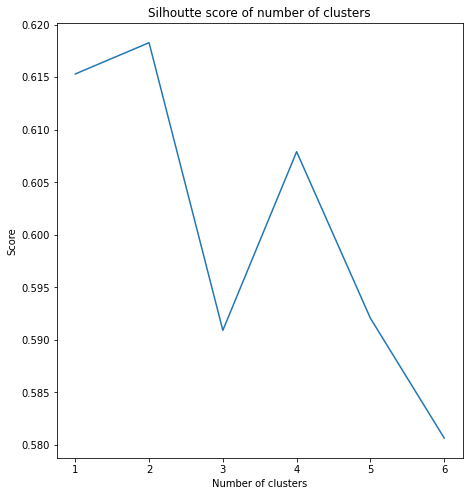

In [16]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

plt.plot(clusters_sil, scores_sil)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"Silhoutte score of number of clusters")

plt.savefig('silhoutte_score_starttime')
plt.show()

### Bayesian information criterion (BIC)

In [17]:
clusters_bic, scores_bic = bic(df_score, 6)

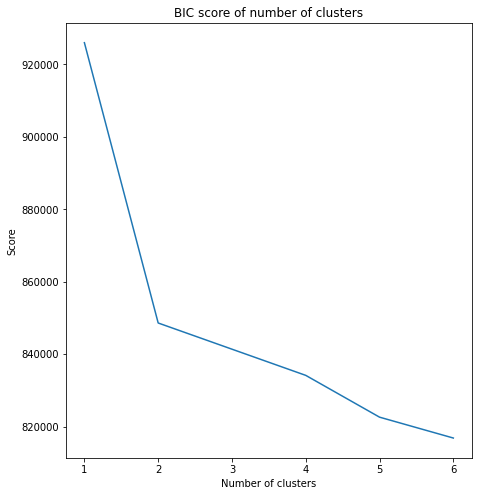

In [18]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

plt.plot(clusters_bic, scores_bic)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"BIC score of number of clusters")

plt.savefig('BIC_score_starttime')
plt.show()

### 1.2 Use Gaussian Mixture Model and discover cluster

In [19]:
gm = GaussianMixture(n_components=4, random_state=42, n_init = 15).fit(df_start_scaled)

In [20]:
cluster = gm.predict(df_start_scaled)

In [21]:
cluster_prob = gm.predict_proba(df_start_scaled)

In [22]:
df_cluster_start["cluster"] = cluster

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_12727/1123111176.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_start["cluster"] = cluster


In [23]:
for k in range(4):
    df_cluster_start[f"cluster_{k}_prob"] = cluster_prob[:, k]

In [24]:
df_cluster_start

,start_time_hourly,cluster,cluster_0_prob,cluster_1_prob,cluster_2_prob,cluster_3_prob
0,0,2,0.001549,8.116161e-19,9.984511e-01,1.372281e-57
1,0,2,0.001549,8.116161e-19,9.984511e-01,1.372281e-57
3,0,2,0.001549,8.116161e-19,9.984511e-01,1.372281e-57
4,0,2,0.001549,8.116161e-19,9.984511e-01,1.372281e-57
5,0,2,0.001549,8.116161e-19,9.984511e-01,1.372281e-57
...,...,...,...,...,...,...
8974512,23,3,0.000185,3.081451e-02,4.584967e-60,9.690002e-01
8974514,23,3,0.000185,3.081451e-02,4.584967e-60,9.690002e-01
8974515,23,3,0.000185,3.081451e-02,4.584967e-60,9.690002e-01
8974517,23,3,0.000185,3.081451e-02,4.584967e-60,9.690002e-01


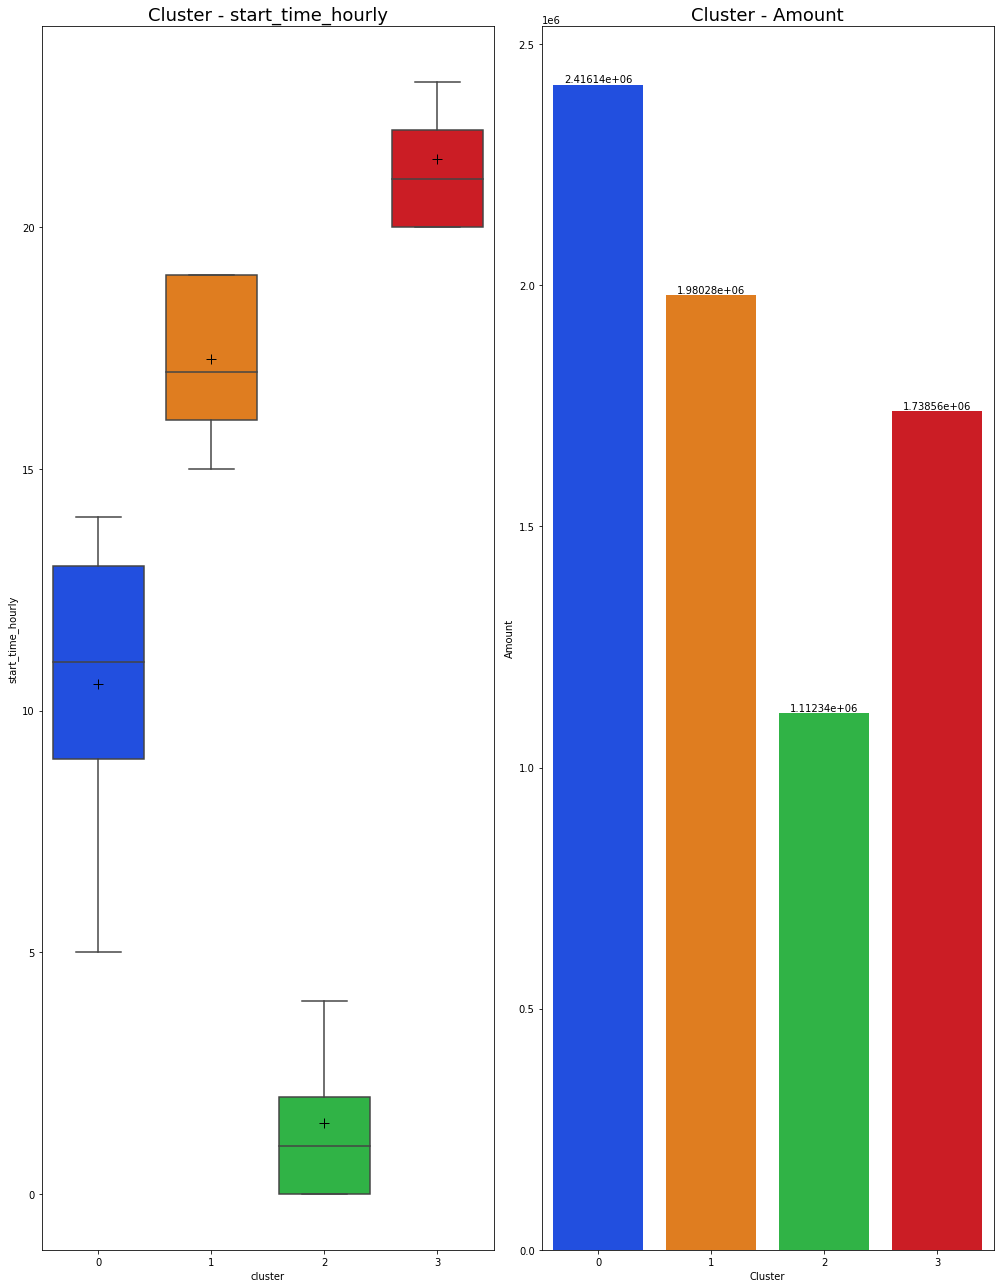

In [25]:
plot_information_about_clusters(df_cluster_start, ['start_time_hourly'], 'cluster')

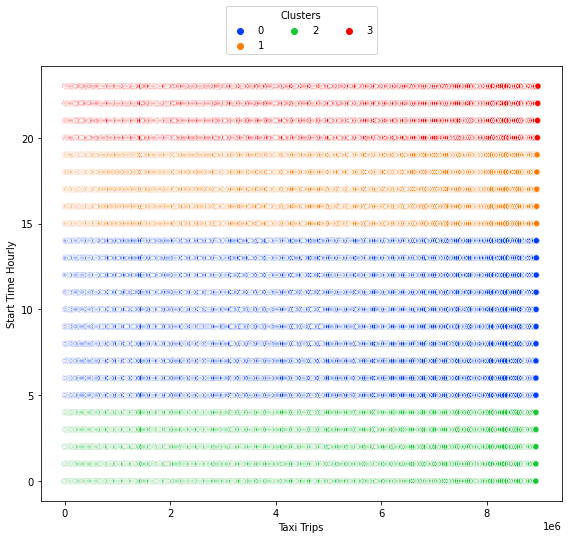

In [64]:
plot_cluster_scatter(df_cluster_start.index, 'start_time_hourly', df_cluster_start, 'Taxi Trips', 'Start Time Hourly')

<hr style="border: 1px solid #8888;">

## 2. Second Cluster Analysis: `Trip_Miles`

#### Scaling the data:

In [26]:
df_cluster_miles = df_chicago_cluster[['Trip_Miles']]

In [27]:
df_miles_scaled = scaling_data(df_cluster_miles)

### 2.1 Decision for number of clusters

In [28]:
df_score = df_miles_scaled.sample(350000, random_state=42)
df_score

,Trip_Miles
7859463,-1.123370
1567295,-1.046943
1532308,-0.511955
8608880,-1.215082
1538808,-0.817662
...,...
3671881,0.099460
4277237,1.093009
5670711,-0.817662
8230356,-0.917017


### Silhouette score

In [29]:
clusters_sil, scores_sil = silhoutte(df_score, 6)

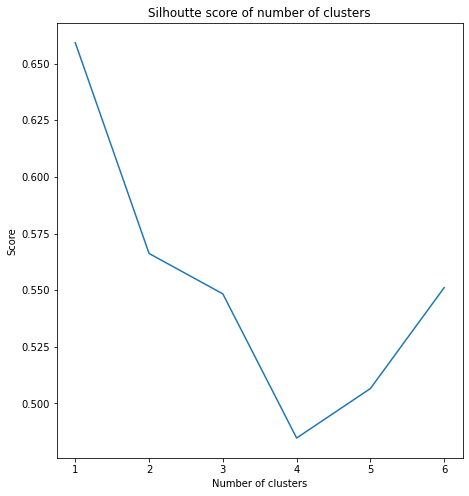

In [30]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_sil, scores_sil)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"Silhoutte score of number of clusters")

plt.savefig('silhoutte_score_miles')
plt.show()

### Bayesian information criterion (BIC)

In [31]:
clusters_bic, scores_bic = bic(df_score, 6)

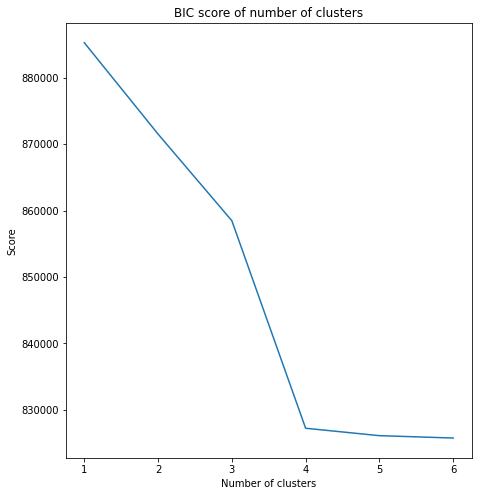

In [32]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_bic, scores_bic)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"BIC score of number of clusters")

plt.savefig('BIC_score_miles')
plt.show()

### 2.2 Use Gaussian Mixture Model and discover cluster

In [48]:
gm = GaussianMixture(n_components=3, random_state=42, n_init = 15).fit(df_miles_scaled)

In [49]:
cluster = gm.predict(df_miles_scaled)

In [50]:
cluster_prob = gm.predict_proba(df_miles_scaled)

In [51]:
df_cluster_miles["cluster"] = cluster

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_12727/2624358545.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_miles["cluster"] = cluster


In [53]:
for k in range(3):
    df_cluster_miles[f"cluster_{k}_prob"] = cluster_prob[:, k]

In [54]:
df_cluster_miles

,Trip_Miles,cluster,cluster_0_prob,cluster_1_prob,cluster_2_prob
0,2.7,2,2.467813e-04,0.265397,0.734356
1,0.4,0,9.577545e-01,0.003228,0.039017
3,1.0,0,8.300077e-01,0.008476,0.161516
4,0.3,0,9.636555e-01,0.003140,0.033205
5,0.8,0,9.010509e-01,0.005352,0.093597
...,...,...,...,...,...
8974512,0.5,0,9.495735e-01,0.003457,0.046970
8974514,5.1,1,4.687840e-20,0.999945,0.000055
8974515,1.4,0,5.023625e-01,0.025430,0.472207
8974517,2.0,2,3.966150e-02,0.080708,0.879630


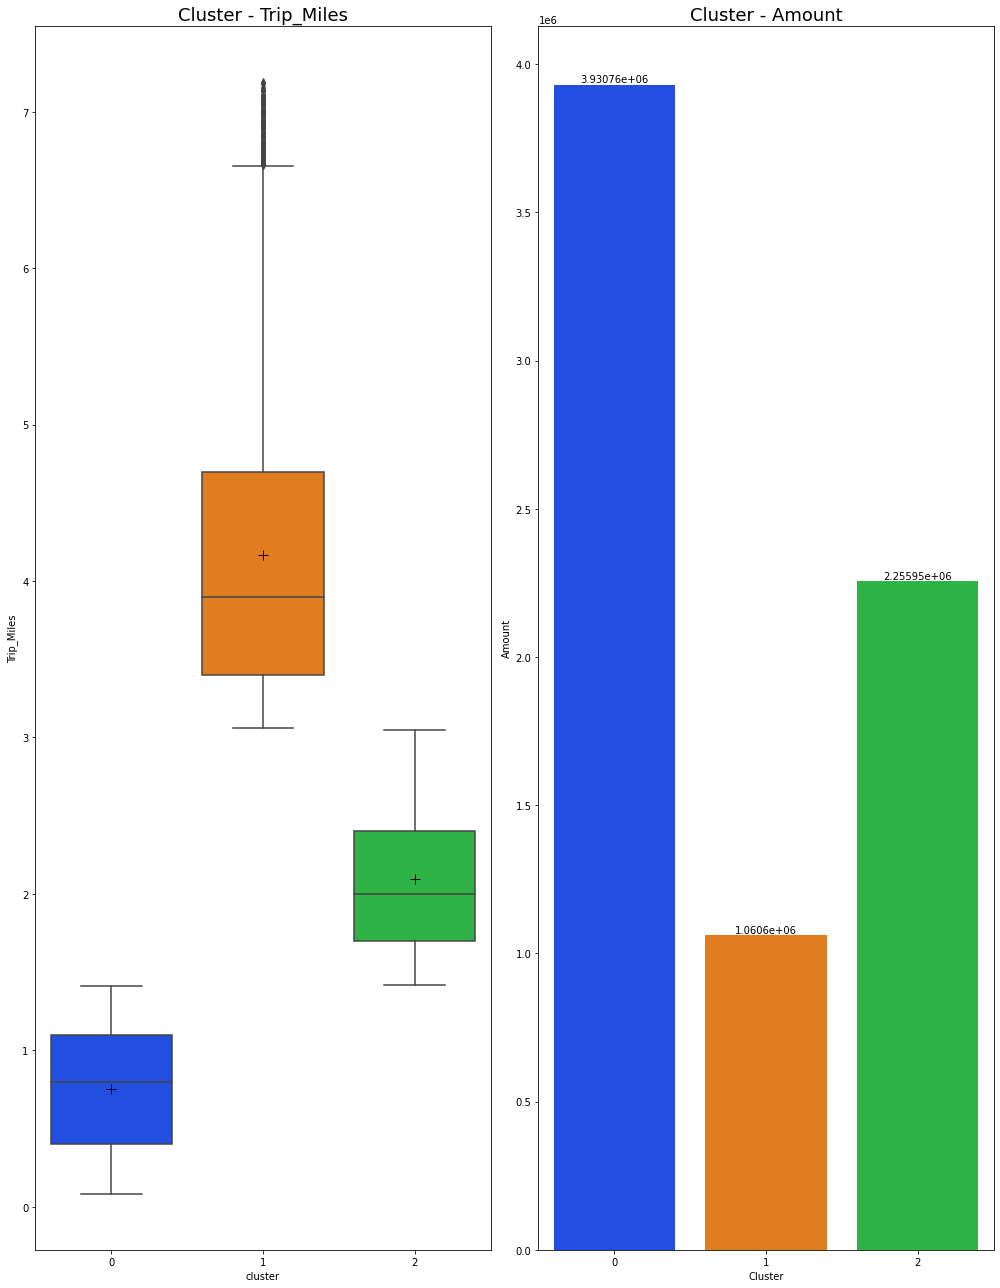

In [55]:
plot_information_about_clusters(df_cluster_miles, ['Trip_Miles'], 'cluster')

In [ ]:
plot_cluster_scatter(df_cluster_start.index, 'Trip_Miles', df_cluster_start, 'Taxi Trips', 'Trip Miles')

<hr style="border: 1px solid #8888;">

## 3. Third Cluster Analysis: `Trip_Minutes`

#### Scaling the data:

In [33]:
df_cluster_minutes = df_chicago_cluster[['Trip_Minutes']]

In [34]:
df_minutes_scaled = scaling_data(df_cluster_minutes)

### 3.1 Decision for number of clusters

In [35]:
df_score = df_minutes_scaled.sample(350000, random_state=42)
df_score

,Trip_Minutes
7859463,0.403036
1567295,0.873073
1532308,-0.537038
8608880,-1.477111
1538808,-1.242093
...,...
3671881,0.403036
4277237,-0.302019
5670711,-1.007074
8230356,0.403036


### Silhouette score

In [36]:
clusters_sil, scores_sil = silhoutte(df_score, 6)

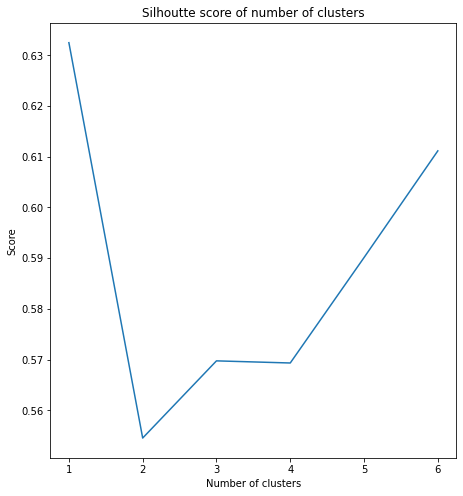

In [37]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_sil, scores_sil)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"Silhoutte score of number of clusters")

plt.savefig('silhoutte_score_minutes')
plt.show()

### Bayesian information criterion (BIC)

In [38]:
clusters_bic, scores_bic = bic(df_score, 6)

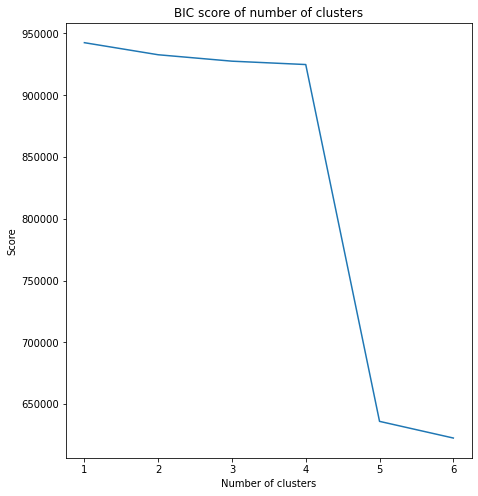

In [39]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_bic, scores_bic)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"BIC score of number of clusters")

plt.savefig('BIC_score_minutes')
plt.show()

### 3.2 Use Gaussian Mixture Model and discover cluster

In [40]:
gm = GaussianMixture(n_components=5, random_state=42, n_init = 15).fit(df_minutes_scaled)

In [41]:
cluster = gm.predict(df_minutes_scaled)

In [42]:
cluster_prob = gm.predict_proba(df_minutes_scaled)

In [43]:
df_cluster_minutes["cluster"] = cluster

/var/folders/rm/wg58__0d187f9f9gt07rpkw40000gn/T/ipykernel_12727/333786254.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_minutes["cluster"] = cluster


In [44]:
for k in range(5):
    df_cluster_minutes[f"cluster_{k}_prob"] = cluster_prob[:, k]

In [45]:
df_cluster_minutes

,Trip_Minutes,cluster,cluster_0_prob,cluster_1_prob,cluster_2_prob,cluster_3_prob,cluster_4_prob
0,15.0,1,1.405756e-13,9.341037e-01,0.027459,3.843684e-02,2.862332e-87
1,4.0,4,2.769192e-01,1.012760e-10,0.008584,7.183772e-26,7.144964e-01
3,3.0,4,7.314536e-02,1.707580e-12,0.002420,3.100481e-29,9.244350e-01
4,4.0,4,2.769192e-01,1.012760e-10,0.008584,7.183772e-26,7.144964e-01
5,8.0,2,3.014629e-01,1.596802e-04,0.698377,7.139574e-14,1.130001e-13
...,...,...,...,...,...,...,...
8974512,3.0,4,7.314536e-02,1.707580e-12,0.002420,3.100481e-29,9.244350e-01
8974514,19.0,3,1.043470e-27,1.197706e-02,0.000008,9.880146e-01,1.405753e-158
8974515,9.0,2,4.462110e-02,1.815642e-03,0.953563,1.649837e-11,3.122675e-20
8974517,12.0,2,2.595991e-06,3.227218e-01,0.677264,1.123667e-05,1.062027e-47


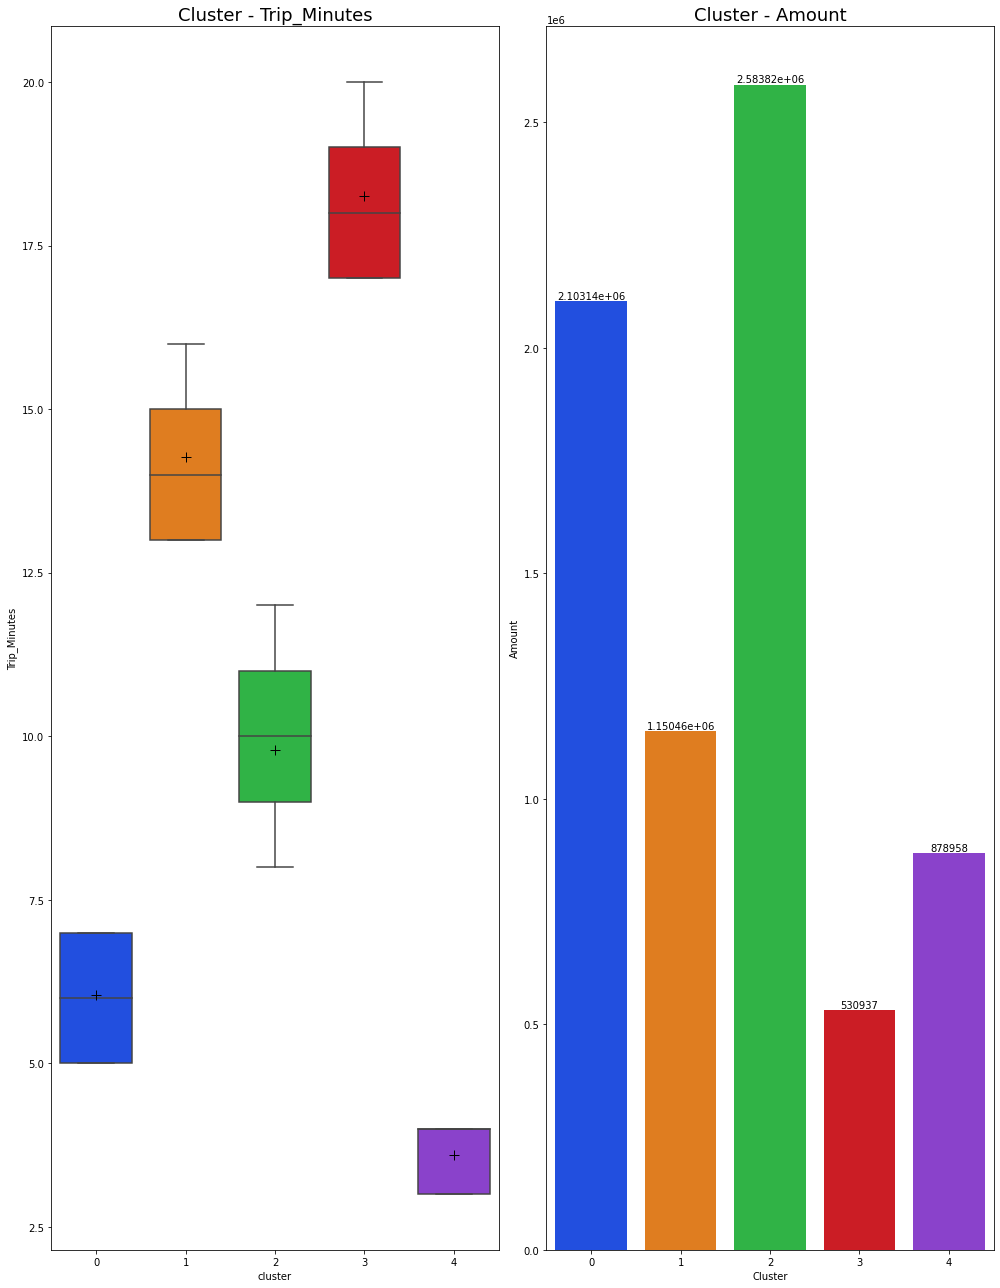

In [47]:
plot_information_about_clusters(df_cluster_minutes, ['Trip_Minutes'], 'cluster')

In [ ]:
plot_cluster_scatter(df_cluster_start.index, 'Trip_Minutes', df_cluster_start, 'Taxi Trips', 'Trip Minutes')

<hr style="border: 1px solid #8888;">

## 4. Fourth Cluster Analysis: `start_time_hourly`, `Trip_Miles` and `Trip_Minutes`

#### Scaling the data:

In [ ]:
df_cluster_scaled = scaling_data(df_chicago_cluster)

In [ ]:
df_cluster_scaled

### 4.1 Decision for number of clusters

In [27]:
df_score = df_cluster_scaled.sample(750000, random_state=42)
df_score

,start_time_hourly,Trip_Miles,Trip_Minutes
7859463,-1.983130,-1.123370,0.403036
1567295,-1.983130,-1.046943,0.873073
1532308,-0.670610,-0.511955,-0.537038
8608880,1.225252,-1.215082,-1.477111
1538808,0.350239,-0.817662,-1.242093
...,...,...,...
5094111,-0.670610,-0.129820,-0.772056
1702540,0.496074,-0.741235,-1.477111
7783643,-1.545624,-0.664808,-1.242093
4667153,0.350239,-1.123370,-0.067001


### Silhouette score

In [28]:
#clusters_sil, scores_sil = silhoutte(df_score, 10)

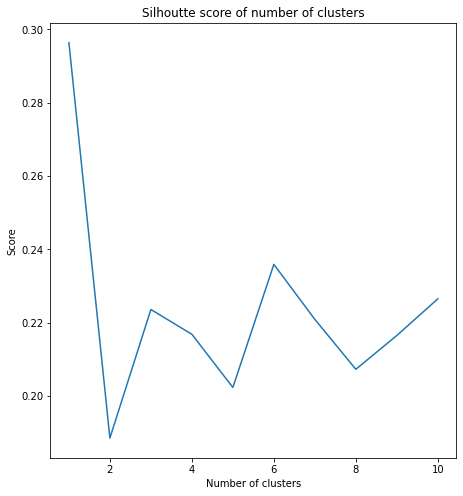

In [61]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_sil, scores_sil)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"Silhoutte score of number of clusters")

plt.savefig('silhoutte_score')
plt.show()

### Bayesian information criterion (BIC)

In [31]:
#clusters_bic, scores_bic = bic(df_score, 10)

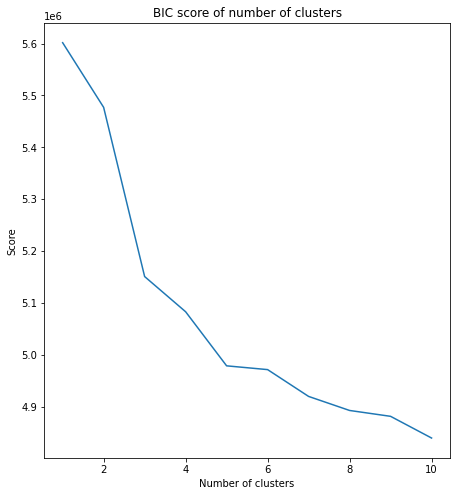

In [59]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)

   # clusters, scores = get_clusters_and_losses(input_data)

plt.plot(clusters_bic, scores_bic)
plt.ylabel("Score")
plt.xlabel("Number of clusters")
plt.title(f"BIC score of number of clusters")

plt.savefig('BIC_score')
plt.show()

### 1.2 Use Gaussian Mixture Model and discover cluster

In [33]:
gm = GaussianMixture(n_components=6, random_state=42, n_init = 15).fit(df_cluster_scaled)

In [34]:
cluster = gm.predict(df_cluster_scaled)

In [35]:
cluster_prob = gm.predict_proba(df_cluster_scaled)

In [36]:
df_chicago_cluster["cluster"] = cluster

In [37]:
for k in range(5):
    df_chicago_cluster[f"cluster_{k}_prob"] = cluster_prob[:, k]

In [38]:
df_chicago_cluster

,start_time_hourly,Trip_Miles,Trip_Minutes,cluster,cluster_0_prob,cluster_1_prob,cluster_2_prob,cluster_3_prob,cluster_4_prob
0,0,2.7,15.0,5,9.241915e-05,3.058123e-19,1.994549e-01,5.906753e-31,3.893079e-257
1,0,0.4,4.0,2,1.320698e-02,2.272388e-24,9.855189e-01,4.903452e-29,2.044949e-05
3,0,1.0,3.0,2,8.551338e-02,1.063691e-25,9.128693e-01,5.616273e-32,2.112221e-40
4,0,0.3,4.0,2,7.928040e-03,3.362586e-24,9.853811e-01,7.761108e-29,5.365695e-03
5,0,0.8,8.0,2,7.312054e-03,2.091962e-21,9.536179e-01,5.872735e-28,8.126666e-18
...,...,...,...,...,...,...,...,...,...
8974512,23,0.5,3.0,3,5.465788e-02,8.863715e-03,7.358218e-96,9.348431e-01,1.817717e-10
8974514,23,5.1,19.0,1,9.925098e-18,9.669726e-01,8.885553e-100,6.378516e-10,0.000000e+00
8974515,23,1.4,9.0,0,4.581682e-01,2.344592e-01,4.574040e-99,2.592919e-01,2.035371e-68
8974517,23,2.0,12.0,1,1.090692e-01,7.237247e-01,1.035550e-100,1.630681e-02,6.001451e-141


### 1.3 Analyze and plot the cluster

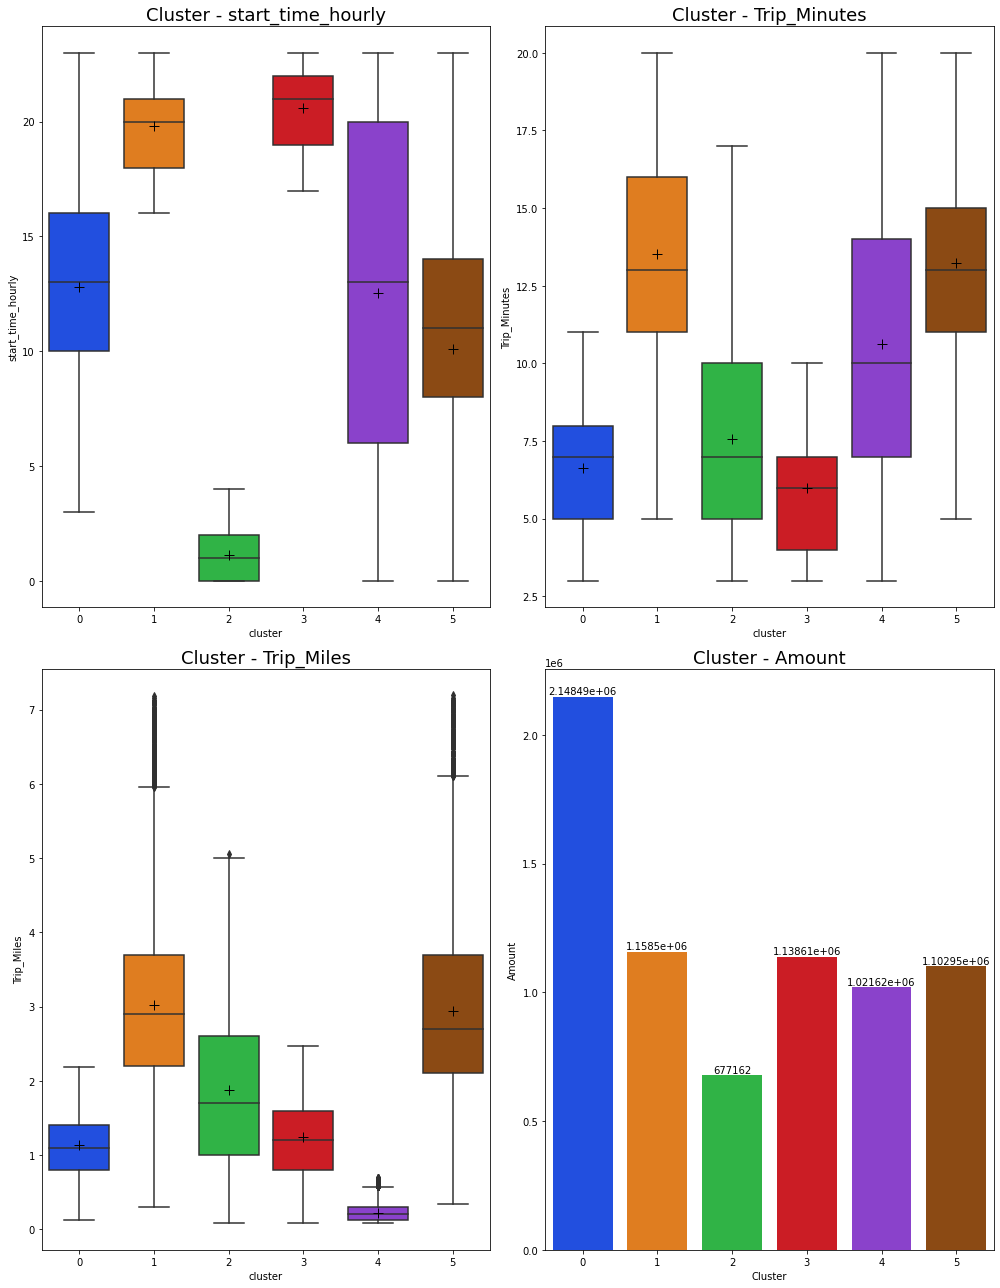

In [41]:
plot_information_about_clusters(df_chicago_cluster, ['start_time_hourly', 'Trip_Minutes', 'Trip_Miles'], 'cluster')

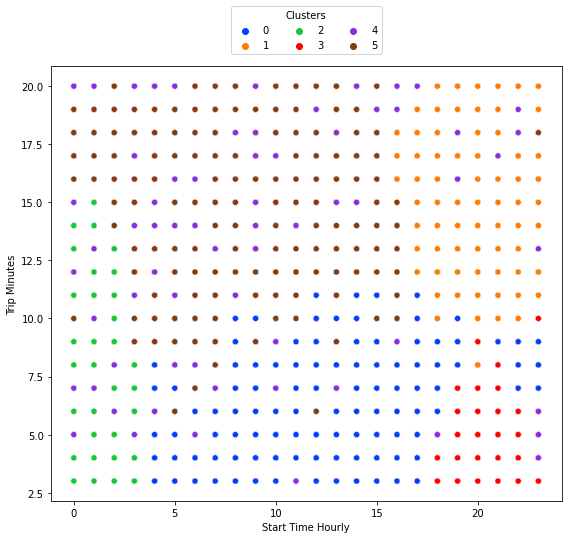

In [53]:
colors = {
    2: '#16C835', #green
    1: '#FF7C00',#orange
    4: '#8B2BE2',#violet
    5: '#843C0C',#brown
    0: '#023EFF',#blue
    6: '#FF1493',#rosa
    3:'#FF0000',#red
    7:'#808080'#grey
    # Add more colors for other clusters if needed
}

# Create the scatter plot
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed

# Use hue parameter to color the data points based on the 'cluster' column
sns.scatterplot(x='start_time_hourly', y='Trip_Minutes',data=df_chicago_cluster,hue='cluster', palette=colors)

# Add labels and legend
plt.xlabel('Start Time Hourly')
plt.ylabel('Trip Minutes')
legend = plt.legend(title='Clusters', loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)  # Adjust the bbox_to_anchor as needed

# Move the legend outside and above the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the top margin (0.95) as needed
# Show the plot
plt.show()

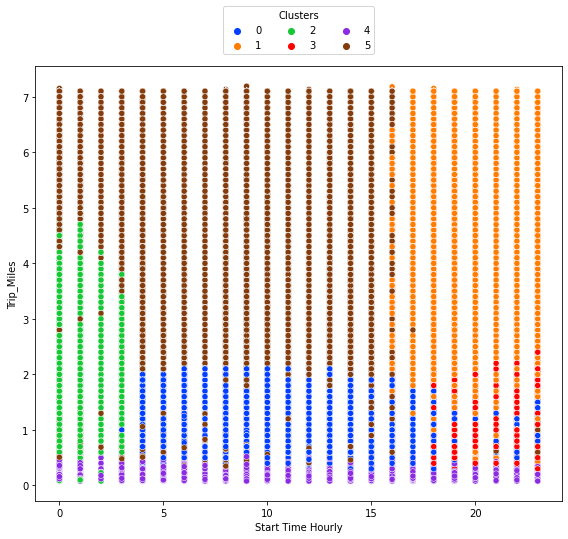

In [45]:
colors = {
    2: '#16C835', #green
    1: '#FF7C00',#orange
    4: '#8B2BE2',#violet
    5: '#843C0C',#brown
    0: '#023EFF',#blue
    6: '#FF1493',#rosa
    3:'#FF0000',#red
    7:'#808080'#grey
    # Add more colors for other clusters if needed
}

# Create the scatter plot
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed

# Use hue parameter to color the data points based on the 'cluster' column
sns.scatterplot(x='start_time_hourly', y='Trip_Miles', data=df_chicago_cluster, hue='cluster', palette=colors)

# Add labels and legend
plt.xlabel('Start Time Hourly')
plt.ylabel('Trip Miles')
legend = plt.legend(title='Clusters', loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)  # Adjust the bbox_to_anchor as needed

# Move the legend outside and above the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the top margin (0.95) as needed
# Show the plot
plt.show()

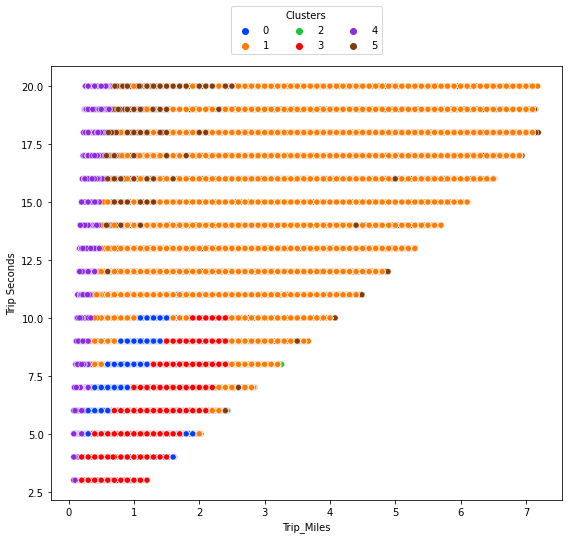

In [47]:
colors = {
    2: '#16C835', #green
    1: '#FF7C00',#orange
    4: '#8B2BE2',#violet
    5: '#843C0C',#brown
    0: '#023EFF',#blue
    6: '#FF1493',#rosa
    3:'#FF0000',#red
    7:'#808080'#grey
    # Add more colors for other clusters if needed
}

# Create the scatter plot
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed

# Use hue parameter to color the data points based on the 'cluster' column
sns.scatterplot(x='Trip_Miles', y='Trip_Minutes', data=df_chicago_cluster, hue='cluster', palette=colors)

# Add labels and legend
plt.xlabel('Trip_Miles')
plt.ylabel('Trip Seconds')
legend = plt.legend(title='Clusters', loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)  # Adjust the bbox_to_anchor as needed

# Move the legend outside and above the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the top margin (0.95) as needed
# Show the plot
plt.show()

### 1.4 Label and define the cluster

In [65]:
def get_quantiles_of_clusters(n_cluster):
    for cluster in range(0,n_cluster):
        dfchicago_c0 = df_chicago_cluster[df_chicago_cluster['cluster']==cluster]
        print('cluster', cluster)
        print('0,25 - quantile')
        print(dfchicago_c0.quantile(q=0.25))
        print('0,75 - quantile')
        print(dfchicago_c0.quantile(q=0.75),'\n')

In [66]:
get_quantiles_of_clusters(6)

cluster 0
0,25 - quantile
start_time_hourly    1.000000e+01
Trip_Miles           8.000000e-01
Trip_Minutes         5.000000e+00
cluster              0.000000e+00
cluster_0_prob       7.578767e-01
cluster_1_prob       1.255861e-07
cluster_2_prob       3.326120e-45
cluster_3_prob       2.839054e-08
cluster_4_prob       1.517313e-75
Name: 0.25, dtype: float64
0,75 - quantile
start_time_hourly    1.600000e+01
Trip_Miles           1.400000e+00
Trip_Minutes         8.000000e+00
cluster              0.000000e+00
cluster_0_prob       9.817817e-01
cluster_1_prob       5.638528e-03
cluster_2_prob       8.708377e-17
cluster_3_prob       1.992204e-02
cluster_4_prob       6.123602e-23
Name: 0.75, dtype: float64 

cluster 1
0,25 - quantile
start_time_hourly    1.800000e+01
Trip_Miles           2.200000e+00
Trip_Minutes         1.100000e+01
cluster              1.000000e+00
cluster_0_prob       3.854125e-09
cluster_1_prob       6.756721e-01
cluster_2_prob       3.395718e-86
cluster_3_prob       3.985

|   clusters | tripstart-hour   | tripduartion-minutes   | tripdistance-miles   |   trpis (#) | trips (in %)   |
|-----------:|:-----------------|:-----------------------|:---------------------|------------:|:---------------|
|          0 | 10-16            | 5-8                    | 0.8 - 1.2            |      144500 | 26%            |
|          1 | 18-21            | 6-9                    | 0.9 - 1.5            |      133988 | 24%            |
|          2 | 0-2              | 11-15                  | 1.5 - 2.1            |      128096 | 23%            |
|          3 | 19-22            | 18-23                  | 2.5 - 3.4            |       69543 | 13%            |
|          4 | 6-20             | 12-16                  | 2.0 - 2.6            |       77617 | 14%            |
|          4 | 8-14             | 12-16                  | 2.0 - 2.6            |       77617 | 14%            |

In [ ]:
df_chicago['chicago_center'] = [41.881832, -87.623177]

In [ ]:
df_chicago["dist_center_pick"] = df_chicago.apply(lambda row: haversine(row["Pickup_Centroid_Location"], row["end"]), axis=1)
df_chicago["dist_center_drop"] = df_chicago.apply(lambda row: haversine(row["Dropoff_Centroid_Location"], row["end"]), axis=1)
df_chicago[["start", "end", "distance (km)"]]

In [ ]:
df_location = df_chicago['Pickup_Community_Area','Pickup_Centroid_Location',]